## Part 1

For our research we will be working with the states of America because they are a great example of different laws towards cannabis and provide wide range of different datasets

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib.patches as mpatches

import re
#import random
import copy
#import sys


Please note, that for example NaN value in Medical marijuana legalized doesn't necessarily mean it's is completely forbidden in a state, it could have some uniquely limited access to it.<br>
Also if marijuana legalized for recreational use it automatically means that medical marijuana is legalized.

In [2]:
data_laws = pd.read_csv("state_marijuana_laws_10_2016.csv")#State laws 2016
#comment the line below to get unshuffled dataframe
data_laws = data_laws.sample(frac=1)
data_laws

,State,Medical marijuana legalized,Marijuana legalized for recreational use,No laws legalizing marijuana
32,South Dakota,NaN,NaN,Yes
29,Ohio,NaN,NaN,Yes
11,Montana,Yes,NaN,NaN
23,Kansas,NaN,NaN,Yes
35,Utah,NaN,NaN,Yes
44,Massachusetts,NaN,Yes,NaN
2,Rhode Island,Yes,NaN,NaN
43,Maine,NaN,Yes,NaN
5,Delaware,Yes,NaN,NaN
34,Texas,NaN,NaN,Yes


Since this way of presenting data is unacceptable we will replace NaN values with 0 and `Yes` with 1.

In [3]:
data_laws.fillna(0, inplace=True)
data_laws.replace('Yes',1, inplace=True)
data_laws.head(6)

,State,Medical marijuana legalized,Marijuana legalized for recreational use,No laws legalizing marijuana
32,South Dakota,0,0,1
29,Ohio,0,0,1
11,Montana,1,0,0
23,Kansas,0,0,1
35,Utah,0,0,1
44,Massachusetts,0,1,0


In [4]:
data_laws.set_index('State',inplace=True)
data_laws = data_laws[data_laws==1].stack().reset_index().drop(0,1)
data_laws.rename(columns={'level_1': 'Marijuana laws status'}, inplace=True)
data_laws.head(6)

,State,Marijuana laws status
0,South Dakota,No laws legalizing marijuana
1,Ohio,No laws legalizing marijuana
2,Montana,Medical marijuana legalized
3,Kansas,No laws legalizing marijuana
4,Utah,No laws legalizing marijuana
5,Massachusetts,Marijuana legalized for recreational use


In [6]:
data_laws

,State,Marijuana laws status
0,South Dakota,No laws legalizing marijuana
1,Ohio,No laws legalizing marijuana
2,Montana,Medical marijuana legalized
3,Kansas,No laws legalizing marijuana
4,Utah,No laws legalizing marijuana
5,Massachusetts,Marijuana legalized for recreational use
6,Rhode Island,Medical marijuana legalized
7,Maine,Marijuana legalized for recreational use
8,Delaware,Medical marijuana legalized
9,Texas,No laws legalizing marijuana


Column with only integers<br>
0 - No laws legalizing marijuana<br>
1 - Medical marijuana legalized<br>
2 - Marijuana legalized for recreational use<br>

In [45]:
data_laws.replace({"No laws legalizing marijuana": 0, "Medical marijuana legalized": 1, "Marijuana legalized for recreational use": 2}, inplace=True)

Now that we know the laws of each state lets move on to marijuana usage.

## Part 2

We will have 3 different datasets that contain info about cannabis usage in states, regions and whole country of USA.<br>
We are going to analyze the data in them to see how much legalization effects percentage of people who smoke cannabis, how it depends on age, how much different is the result comparing to other bad habitats and so on.
All of the datasets below use the data given by NSDUH(National Survey on Drug Use and Health) so there is no need to compare them.

In [7]:
data_regions = pd.read_csv("marijuana-use-2016.csv")
data_regions.head(6)

,Region,Year,Age Range,Marijuana Use,Measure Type,Variable,Value
0,Connecticut,2004-2006,12-17,First Use of Marijuana,Percent,Margins of Error,0.91
1,Connecticut,2004-2006,12-17,First Use of Marijuana,Percent,Marijuana Use,7.62
2,Connecticut,2004-2006,12-17,Marijuana Use in the Past Month,Percent,Margins of Error,1.38
3,Connecticut,2004-2006,12-17,Marijuana Use in the Past Month,Percent,Marijuana Use,8.39
4,Connecticut,2004-2006,12-17,Marijuana Use in the Past Year,Percent,Margins of Error,1.88
5,Connecticut,2004-2006,12-17,Marijuana Use in the Past Year,Percent,Marijuana Use,17.79


This dataset contains info on marijuana usage in diiferent regions of America and is devided by years and age group.<br>
As we can see every row is duplicated twice except of two last columns that differ<br>
We will join them to improve quality of our dataset and then move on for now.

In [8]:
data_regions["Margins of Error"] = np.nan
data_regions["Marijuana Usege (times per last year)"] = np.nan
for i in range(int(len(data_regions) / 2)):
    to_merge = data_regions.loc[(data_regions['Region'] == data_regions['Region'].iloc[i]) & 
                     (data_regions['Year'] == data_regions['Year'].iloc[i]) & 
                     (data_regions['Age Range'] == data_regions['Age Range'].iloc[i]) & 
                     (data_regions['Marijuana Use'] == data_regions['Marijuana Use'].iloc[i])]
    data_regions["Margins of Error"].iloc[i] = to_merge.loc[data_regions["Variable"] == "Margins of Error"].iloc[0]["Value"]
    data_regions["Marijuana Usege (times per last year)"].iloc[i] = to_merge.loc[data_regions["Variable"] == "Marijuana Use"].iloc[0]["Value"]
    #data_regions["Margins of Error"].iloc[i].fillna(to_merge.loc[data_regions["Variable"] == "Margins of Error"].iloc[0]["Value"], inplace=True)
    #data_regions["Marijuana Usege (times per last year)"].iloc[i].fillna(to_merge.loc[data_regions["Variable"] == "Marijuana Use"]["Value"], inplace=True)
    data_regions = data_regions.drop(data_regions.index[i + 1])
    
del data_regions["Measure Type"]
del data_regions["Variable"]
del data_regions["Value"]

/home/roman/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
data_regions.head(6)

,Region,Year,Age Range,Marijuana Use,Margins of Error,Marijuana Usege (times per last year)
0,Connecticut,2004-2006,12-17,First Use of Marijuana,0.91,7.62
2,Connecticut,2004-2006,12-17,Marijuana Use in the Past Month,1.38,8.39
4,Connecticut,2004-2006,12-17,Marijuana Use in the Past Year,1.88,17.79
6,Connecticut,2004-2006,18-25,First Use of Marijuana,1.49,8.33
8,Connecticut,2004-2006,18-25,Marijuana Use in the Past Month,2.62,23.34
10,Connecticut,2004-2006,18-25,Marijuana Use in the Past Year,3.08,37.72


Our next dataset is actually a set of smaller datasets<br>
They contain number(in thousands) of uses of particular type(every type in another dataset, for example dataset of `Marijuana Use in the Past Year, by Age Group and State: Estimated Numbers (in Thousands), Annual Averages Based on 2015 and 2016 NSDUHs`)<br>
Theu use have 95 percent confidence intervals with small margins of error so we will drop the 95% Confidence Interval Lower and Upper.
Also there  is documantation on a dataset which you can read in first few rows of it but will skip for our dataframe.

Marijuana Use in the Past Year, by Age Group and State: Estimated Numbers (in Thousands), Annual Averages Based on 2015 and 2016 NSDUHs

In [109]:
data2 = pd.read_csv("NSDUH_Totals2016/NSDUHsaeTotals-Tab02-2016.csv")
data2.columns = data2.iloc[4]
data2 = data2[5:]
data2.head(6)

4,Order,State,12 or Older Estimate,12 or Older 95% CI (Lower),12 or Older 95% CI (Upper),12-17 Estimate,12-17 95% CI (Lower),12-17 95% CI (Upper),18-25 Estimate,18-25 95% CI (Lower),18-25 95% CI (Upper),26 or Older Estimate,26 or Older 95% CI (Lower),26 or Older 95% CI (Upper),18 or Older Estimate,18 or Older 95% CI (Lower),18 or Older 95% CI (Upper)
5,1,Total U.S.,"36,806","36,047","37,580","3,060","2,951","3,171","11,323","11,077","11,573","22,424","21,784","23,079","33,747","32,998","34,510"
6,2,Northeast,"7,094","6,802","7,400",509,475,545,"2,279","2,192","2,366","4,306","4,040","4,588","6,585","6,296","6,886"
7,3,Midwest,"7,405","7,115","7,703",676,638,717,"2,342","2,265","2,421","4,386","4,122","4,665","6,729","6,443","7,023"
8,4,South,"11,860","11,417","12,317","1,070","1,014","1,128","3,824","3,706","3,944","6,967","6,559","7,397","10,791","10,354","11,243"
9,5,West,"10,447","10,040","10,867",804,753,859,"2,878","2,769","2,990","6,764","6,388","7,158","9,642","9,240","10,059"
10,6,Alabama,386,335,444,38,31,47,135,118,154,212,171,262,348,299,404


First Use of Marijuana, by Age Group and State: Average Annual Number of Marijuana Initiates (Expressed as Numbers in Thousands of the At-Risk Population), Based on 2015 and 2016 NSDUHs

In [110]:
data5 = pd.read_csv("NSDUH_Totals2016/NSDUHsaeTotals-Tab05-2016.csv")
data5.columns = data5.iloc[5]
data5 = data5[6:]
data5.head(5)

5,Order,State,12 or Older Estimate,12 or Older 95% CI (Lower),12 or Older 95% CI (Upper),12-17 Estimate,12-17 95% CI (Lower),12-17 95% CI (Upper),18-25 Estimate,18-25 95% CI (Lower),18-25 95% CI (Upper),26 or Older Estimate,26 or Older 95% CI (Lower),26 or Older 95% CI (Upper),18 or Older Estimate,18 or Older 95% CI (Lower),18 or Older 95% CI (Upper)
6,1,Total U.S.,"3,002","2,894","3,113","1,169","1,122","1,219","1,392","1,322","1,466",440,387,502,"1,833","1,737","1,933"
7,2,Northeast,543,507,581,197,182,213,261,239,285,85,68,105,346,316,379
8,3,Midwest,648,611,688,251,236,268,311,288,336,86,70,105,397,366,431
9,4,South,"1,037",978,"1,099",426,402,452,479,445,516,131,107,160,610,562,662
10,5,West,774,723,830,295,273,319,340,310,373,139,113,170,479,436,527


In [111]:
def data_clean(data):
    to_del = [col for col in data.columns if ("(Lower)" in col or "(Upper)" in col)]
    to_del.append("Order")
    for i in to_del:
        del data[i]

    for col in data.columns[1:]:
        data[col] = pd.to_numeric(data[col].apply(lambda x: re.sub(',','',x)))
    data = data[data.State != 'District of Columbia']
    return data


In [112]:
data_laws = data_laws.sort_values("Marijuana laws status")
data2_forplot = data_clean(data2[5:])
data5_forplot = data_clean(data5[5:])

states = list(data_laws.sort_values("State")["State"])

/home/roman/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


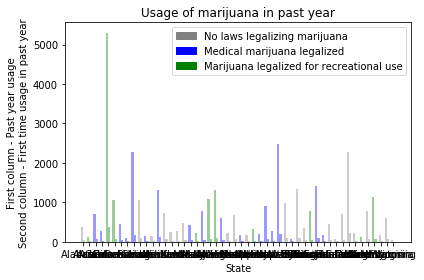

In [160]:
grey_patch = mpatches.Patch(color='grey', label='No laws legalizing marijuana')
blue_patch = mpatches.Patch(color='b', label='Medical marijuana legalized')
green_patch = mpatches.Patch(color='g', label='Marijuana legalized for recreational use')


n_groups = len(states)
colors = []
for st in states:
    if int(data_laws.loc[data_laws["State"] == st]["Marijuana laws status"]) == 0:
        colors.append('grey')
    elif int(data_laws.loc[data_laws["State"] == st]["Marijuana laws status"]) == 1:
        colors.append('b')
    else:
        colors.append('g')

means1 = list(data2_forplot["12 or Older Estimate"])

means2 = list(data5_forplot["12 or Older Estimate"])


fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means1, bar_width,
                alpha=opacity, color=colors, error_kw=error_config,
                label='Past year')

rects2 = ax.bar(index + bar_width, means2, bar_width,
                alpha=opacity, color=colors, error_kw=error_config,
                label='First usage')

ax.set_xlabel('States')
ax.set_ylabel("First column - Past year usage\nSecond column - First time usage in past year")
ax.set_title('Usage of marijuana in past year')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(states)
#ax.legend()
ax.legend(handles=[grey_patch, blue_patch, green_patch])


# spos = Slider(axpos, 'Pos', 0.1, 90.0)
# def update(val):
#     pos = spos.val
#     ax.axis([pos,pos+10,-1,1])
#     fig.canvas.draw_idle()

# spos.on_changed(update)

fig.tight_layout()
plt.show()

Marijuana Use in the Past Month, by Age Group and State: Estimated Numbers (in Thousands), Annual Averages Based on 2015 and 2016 NSDUHs

In [40]:
data3 = pd.read_csv("NSDUH_Totals2016/NSDUHsaeTotals-Tab03-2016.csv")
data3.columns = data3.iloc[4]
data3 = data3[5:]
data3.head(5)

4,Order,State,12 or Older Estimate,12 or Older 95% CI (Lower),12 or Older 95% CI (Upper),12-17 Estimate,12-17 95% CI (Lower),12-17 95% CI (Upper),18-25 Estimate,18-25 95% CI (Lower),18-25 95% CI (Upper),26 or Older Estimate,26 or Older 95% CI (Lower),26 or Older 95% CI (Upper),18 or Older Estimate,18 or Older 95% CI (Lower),18 or Older 95% CI (Upper)
5,1,Total U.S.,"23,103","22,505","23,717","1,681","1,601","1,764","7,052","6,848","7,262","14,370","13,864","14,894","21,423","20,832","22,029"
6,2,Northeast,"4,539","4,317","4,771",294,268,322,"1,438","1,366","1,514","2,807","2,612","3,015","4,245","4,028","4,473"
7,3,Midwest,"4,697","4,483","4,920",357,330,385,"1,425","1,356","1,496","2,916","2,728","3,114","4,340","4,131","4,558"
8,4,South,"7,099","6,782","7,430",583,540,629,"2,287","2,190","2,388","4,229","3,952","4,524","6,516","6,208","6,838"
9,5,West,"6,768","6,454","7,096",446,408,489,"1,902","1,803","2,005","4,419","4,140","4,716","6,321","6,015","6,641"


 Perceptions of Great Risk from Smoking Marijuana Once a Month, by Age Group and State: Estimated Numbers (in Thousands), Annual Averages Based on 2015 and 2016 NSDUHs

In [41]:
data4 = pd.read_csv("NSDUH_Totals2016/NSDUHsaeTotals-Tab04-2016.csv")
data4.columns = data4.iloc[4]
data4 = data4[5:]
data4.head(5)

4,Order,State,12 or Older Estimate,12 or Older 95% CI (Lower),12 or Older 95% CI (Upper),12-17 Estimate,12-17 95% CI (Lower),12-17 95% CI (Upper),18-25 Estimate,18-25 95% CI (Lower),18-25 95% CI (Upper),26 or Older Estimate,26 or Older 95% CI (Lower),26 or Older 95% CI (Upper),18 or Older Estimate,18 or Older 95% CI (Lower),18 or Older 95% CI (Upper)
5,1,Total U.S.,"76,344","75,083","77,520","6,763","6,600","6,929","4,975","4,803","5,152","64,606","63,441","65,781","69,581","68,340","70,733"
6,2,Northeast,"12,649","12,218","13,073","1,104","1,054","1,154",764,711,821,"10,782","10,383","11,188","11,546","11,122","11,961"
7,3,Midwest,"14,502","14,065","14,927","1,412","1,359","1,466",924,868,983,"12,166","11,774","12,567","13,090","12,663","13,505"
8,4,South,"32,338","31,632","33,017","2,828","2,736","2,922","2,151","2,052","2,254","27,359","26,726","27,999","29,510","28,818","30,173"
9,5,West,"16,855","16,318","17,377","1,419","1,350","1,490","1,136","1,059","1,218","14,300","13,811","14,798","15,436","14,909","15,948"


This dataset has data based on all US states but for all ages<br>
*-use - percentage of those in an age group who used * in the past 12 months<br>
*-frequency - median number of times a user in an age group used * in the past 12 months

In [16]:
data_all_uses = pd.read_csv("drug-use-by-age.csv")#Bad habitats by age 2015
data_all_uses

,age,n,alcohol-use,alcohol-frequency,marijuana-use,marijuana-frequency,cocaine-use,cocaine-frequency,crack-use,crack-frequency,...,oxycontin-use,oxycontin-frequency,tranquilizer-use,tranquilizer-frequency,stimulant-use,stimulant-frequency,meth-use,meth-frequency,sedative-use,sedative-frequency
0,12,2798,3.9,3.0,1.1,4.0,0.1,5.0,0.0,-,...,0.1,24.5,0.2,52.0,0.2,2.0,0.0,-,0.2,13.0
1,13,2757,8.5,6.0,3.4,15.0,0.1,1.0,0.0,3.0,...,0.1,41.0,0.3,25.5,0.3,4.0,0.1,5.0,0.1,19.0
2,14,2792,18.1,5.0,8.7,24.0,0.1,5.5,0.0,-,...,0.4,4.5,0.9,5.0,0.8,12.0,0.1,24.0,0.2,16.5
3,15,2956,29.2,6.0,14.5,25.0,0.5,4.0,0.1,9.5,...,0.8,3.0,2.0,4.5,1.5,6.0,0.3,10.5,0.4,30.0
4,16,3058,40.1,10.0,22.5,30.0,1.0,7.0,0.0,1.0,...,1.1,4.0,2.4,11.0,1.8,9.5,0.3,36.0,0.2,3.0
5,17,3038,49.3,13.0,28.0,36.0,2.0,5.0,0.1,21.0,...,1.4,6.0,3.5,7.0,2.8,9.0,0.6,48.0,0.5,6.5
6,18,2469,58.7,24.0,33.7,52.0,3.2,5.0,0.4,10.0,...,1.7,7.0,4.9,12.0,3.0,8.0,0.5,12.0,0.4,10.0
7,19,2223,64.6,36.0,33.4,60.0,4.1,5.5,0.5,2.0,...,1.5,7.5,4.2,4.5,3.3,6.0,0.4,105.0,0.3,6.0
8,20,2271,69.7,48.0,34.0,60.0,4.9,8.0,0.6,5.0,...,1.7,12.0,5.4,10.0,4.0,12.0,0.9,12.0,0.5,4.0
9,21,2354,83.2,52.0,33.0,52.0,4.8,5.0,0.5,17.0,...,1.3,13.5,3.9,7.0,4.1,10.0,0.6,2.0,0.3,9.0


Now let's vizualize some of the date we've got now and than analyze it.

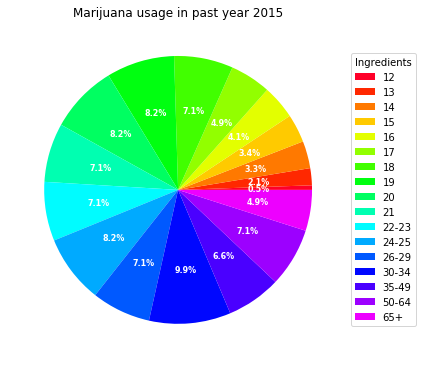

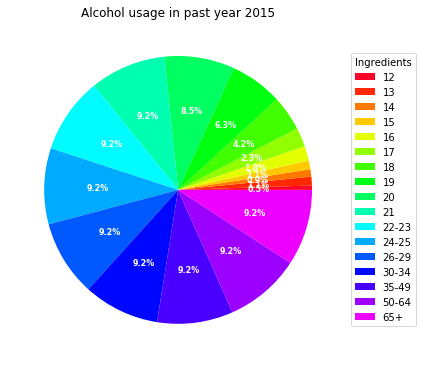

In [159]:
def pie_diagram(column, caption):
    fig, ax = plt.subplots(figsize=(6, 13), subplot_kw=dict(aspect="equal"))

    data = list(data_all_uses[column])
    ingredients = list(data_all_uses["age"])
    cm = plt.get_cmap('gist_rainbow')

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%".format(pct, absolute)


    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"), colors=[cm(1.*i/len(ingredients)) for i in range(len(ingredients))])

    ax.legend(wedges, ingredients,
              title="Ingredients",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=8, weight="bold")
    ax.set_title(caption)
    
    #ax.set_color_cycle([cm(1.*i/20) for i in range(20)])
    plt.show()
pie_diagram("marijuana-frequency", "Marijuana usage in past year 2015")
pie_diagram("alcohol-frequency", "Alcohol usage in past year 2015")

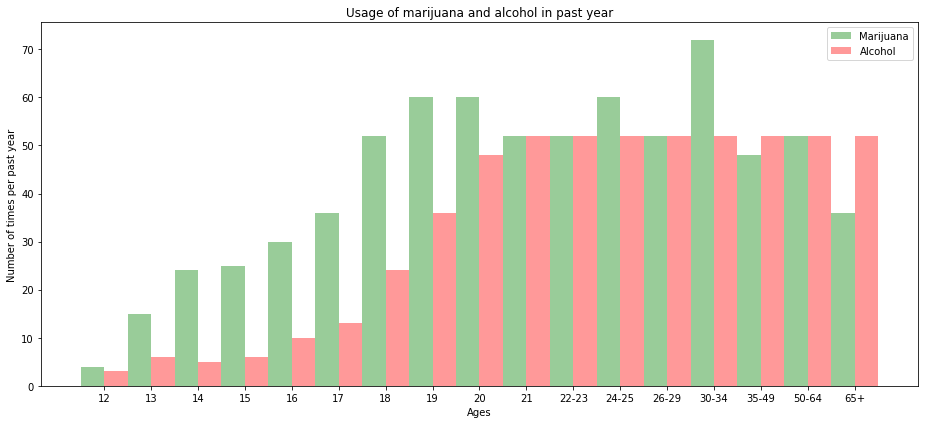

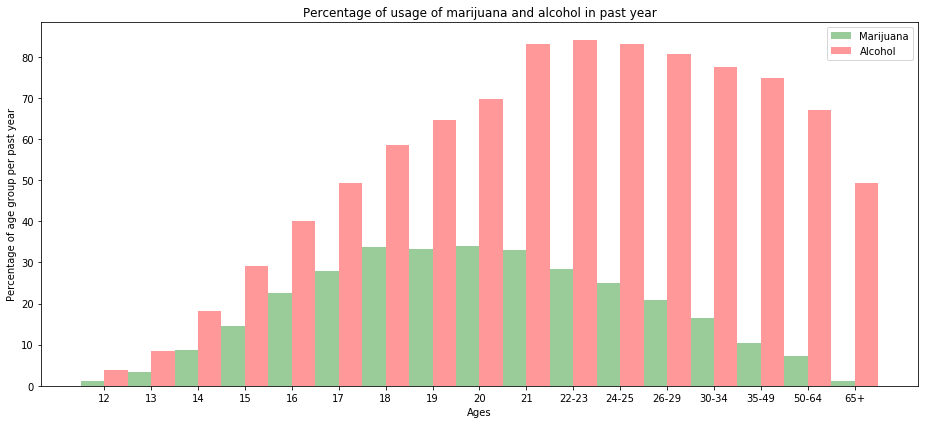

In [177]:
def histo(type1, type2, type3):
    n_groups = len(data_all_uses["age"])

    means1 = list(data_all_uses["marijuana-" + type1])
    means2 = list(data_all_uses["alcohol-" + type1])

    fig, ax = plt.subplots(figsize=(13, 6))

    index = np.arange(n_groups)
    bar_width = 0.5

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index, means1, bar_width,
                    alpha=opacity, color='g', error_kw=error_config,
                    label='Marijuana')

    rects2 = ax.bar(index + bar_width, means2, bar_width,
                    alpha=opacity, color='r', error_kw=error_config,
                    label='Alcohol')

    ax.set_xlabel('Ages')
    ax.set_ylabel(type2 + "per past year")
    ax.set_title(type3 + 'sage of marijuana and alcohol in past year')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(list(data_all_uses["age"]))
    ax.legend()

    fig.tight_layout()
    plt.show()
histo("frequency", "Number of times ", "U")
histo("use", "Percentage of age group ", "Percentage of u")

We can also compare the usage of cannabis in US with the rest of the world by using following datasets<br>
Column `VALUE` tells us the percentage out of 100% of this particular age, gender and country who[]
Column `SIGNIF_GENDER` tells us whether difference in value is significant or not

In [17]:
data_eu1 = pd.read_csv("european_countries/HBSC_26_EN.csv")#15y.o., 2014
data_eu1 = data_eu1[:-5]

In [18]:
#data_eu1

HBSC Members are all the countries provided in the dataset.<br>
Column `COUNTRY_GRP`(Country Group) is almost empty except last 3 entries so we will drop it and replace values of column `COUNTRY` for those 3 rows to HBSC_MEMBER

In [19]:
data_eu1["COUNTRY"][-3:].replace(np.nan, "HBSC_MEMBER", inplace=True)
del data_eu1["COUNTRY_GRP"]
data_eu1 = data_eu1[:-1]

In [20]:
print(data_eu1["AGE_GRP_2"].unique())
print(data_eu1["YEAR"].unique())
del data_eu1["AGE_GRP_2"]
del data_eu1["YEAR"]

['15YO']
[2014.]


Since columns `AGE_GRP_2` and `YEAR` have always the same value we will drop them<br>
We will also put gender as a column and it's percentage as value of this column

In [21]:
data_eu1["FEMALE_VALUE"] = np.nan
data_eu1["MALE_VALUE"] = np.nan
for i in range(int(len(data_eu1) / 2)):
    to_merge = data_eu1.loc[(data_eu1['COUNTRY'] == data_eu1['COUNTRY'].iloc[i])]
    data_eu1["FEMALE_VALUE"].iloc[i] = to_merge.loc[data_eu1["SEX"] == "FEMALE"].iloc[0]["VALUE"]
    data_eu1["MALE_VALUE"].iloc[i] = to_merge.loc[data_eu1["SEX"] == "MALE"].iloc[0]["VALUE"]
    data_eu1 = data_eu1.drop(data_eu1.index[i + 1])
    
del data_eu1["SEX"]
del data_eu1["VALUE"]
data_eu1["SIGNIF_GENDER"].iloc[-1] = "SIGNIF"

/home/roman/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
data_eu1

,COUNTRY,SIGNIF_GENDER,FEMALE_VALUE,MALE_VALUE
0,UKR,SIGNIF,1.0,3.0
2,SWE,SIGNIF,1.0,2.0
4,SVN,NOTSIGNIF,2.0,3.0
6,RUS,NOTSIGNIF,4.0,3.0
8,ROU,SIGNIF,1.0,4.0
10,PRT,NOTSIGNIF,2.0,4.0
12,POL,NOTSIGNIF,4.0,5.0
14,NLD,NOTSIGNIF,3.0,4.0
16,MLT,NOTSIGNIF,3.0,3.0
18,MDA,SIGNIF,0.0,1.0


## Part 3

In [36]:
data_sales = pd.read_csv("marijuana_gross_sales.csv")#Permitted Medical Cannabis Dispensaries 
data_sales["Medical Total Gross Sales"] = np.nan
data_sales["Retail Total Gross Sales"] = np.nan
for i in range(int(len(data_sales) / 2)):
    to_merge = data_sales.loc[(data_sales['YEAR'] == data_sales['YEAR'].iloc[i]) & (data_sales['MONTH'] == data_sales['MONTH'].iloc[i])]
    data_sales["Medical Total Gross Sales"].iloc[i] = to_merge.loc[data_sales["GROSS_SALES_TYPE"] == "Medical Total Gross Sales"].iloc[0]["GROSS_SALES"]
    data_sales["Retail Total Gross Sales"].iloc[i] = to_merge.loc[data_sales["GROSS_SALES_TYPE"] == "Retail Total Gross Sales"].iloc[0]["GROSS_SALES"]
    data_sales = data_sales.drop(data_sales.index[i + 1])
    
del data_sales["GROSS_SALES_TYPE"]
del data_sales["GROSS_SALES"]
data_sales

/home/roman/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,YEAR,MONTH,Medical Total Gross Sales,Retail Total Gross Sales
0,2017,SEPTEMBER,18314027.40,34950895.10
2,2017,AUGUST,19043315.07,35240979.02
4,2017,JULY,17922958.90,34815762.24
6,2017,JUNE,17615041.10,31908811.19
8,2017,MAY,18276904.11,30671594.41
10,2017,APRIL,19070684.93,30302993.01
12,2017,MARCH,18130410.96,30670923.08
14,2017,FEBRUARY,14533972.60,25352587.41
16,2017,JANUARY,15455178.08,25754881.12
18,2016,DECEMBER,15609013.70,27363748.25


In [24]:
data_tax = pd.read_csv("marijuana_sales_tax_2015.csv", header=1)
for col in data_tax.columns[1:]:
    data_tax[col] = pd.to_numeric(data_tax[col].apply(lambda x: re.sub(',','',x[1:-2])))
data_tax

,2015,Retail Marijuana Combined Sales Tax Total (Includes Standard Sales Tax Rate and Special 3.5% Retail Sales Tax Rate),Special 3.5% Special Marijuana Retail Sales Tax Rate ONLY,Medical MJ Sales Tax Total
0,January,1094978.0,536003.2,510132.0
1,February,1020184.0,499390.7,491069.0
2,March,1207890.0,591274.8,544085.0
3,April,1374986.0,673070.0,568703.0
4,May,1310181.0,641347.3,558107.0
5,June,1274621.0,623940.3,579968.0
6,July,1418052.0,694151.3,733949.0
7,August,1478473.0,723728.0,694621.0
8,September,1484782.0,726816.3,667360.0
9,October,1365683.0,668516.1,624931.0


In [25]:
data_revenue = pd.read_csv("tax_revenue2018.csv")
for col in [i for i in data_revenue.columns[1:] if '%' not in i]:
    data_revenue[col] = pd.to_numeric(data_revenue[col].apply(lambda x: re.sub('\.','',x)))
data_revenue

,MONTH,Retail Gross Sales,Retail Special,Retail Sales Tax,Retail Sales Tax Total,Last Year Retail Sales Tax Total,YoY % Retail Sales Tax Total,Medical Gross Sales,Medical Sales Tax,Last year Medical Sales Tax,YoY % Medical Sales Tax,Retail & Medical Sales Tax Total,Last Year Retail & Medical Sales Tax,YoY % Retail & Medical Sales Tax
0,January,29455423,1030945,1075117,2106062,1841552,14.4,14070685,513580,564015,-8.9,2619642,2405567,8.9
1,February,27832113,974130,1015868,1989998,1815650,9.6,12025370,438926,524892,-164.0,2428924,2340542,3.8
2,March,34738044,1215828,1267947,2483775,2199043,12.9,13687233,499584,656681,-23.9,2983359,2855724,4.5
3,April,33977468,1189209,1240183,2429392,2166359,12.1,12842356,468746,692897,-32.3,2898138,2859256,1.4
4,May,31713084,1109954,1157530,2267484,2189671,3.6,12482411,455608,670549,-32.1,2723092,2860220,-4.8
5,June,32757602,1146522,1195649,2342171,2276298,2.9,12220466,446047,648705,-31.2,2788218,2925003,-4.7
6,July,34398616,1203948,1255549,2459497,2467141,-0.3,12471260,455201,654490,-30.4,2914698,3121631,-6.6
7,August,35612280,1246427,1299852,2546279,2519730,1.1,13767123,502500,696146,-27.8,3048779,3215876,-5.2
8,September,34210068,1197342,1248680,2446022,2519035,-2.9,13735260,501337,662939,-24.4,2947359,3181974,-7.4
9,October,32307161,1776895,1179217,2956112,2419056,22.2,12981973,473842,633462,-25.2,3429954,3052518,12.4


In [26]:
# Total Gross Domestic Product for Colorado
data_gdp = pd.read_csv("economy/CONGSP.csv") #Millions of Dollars,Not Seasonally Adjusted
data_gdp.columns = ["Year", "GDP(millions)"]
data_gdp["Year"] = pd.to_numeric(data_gdp["Year"].apply(lambda x: re.sub('-01-01','',x)))
data_gdp

,Year,GDP(millions)
0,1997,136675.3
1,1998,150381.7
2,1999,164226.8
3,2000,180605.5
4,2001,187571.9
5,2002,190962.8
6,2003,196483.7
7,2004,203980.2
8,2005,219907.9
9,2006,231205.9


In [27]:
# GDP by state and year
data_econ = pd.read_csv("economy/Energy Census and Economic Data US 2010-2014.csv")
left = [col for col in data_econ.iloc[:, 137:162].columns if "Q" not in col]
left = ["StateCodes", "State"] + left
data_econ = data_econ[left]
data_econ

,StateCodes,State,GDP2010,GDP2011,GDP2012,GDP2013,GDP2014
0,AL,Alabama,176220.75,181923.00,187283.25,191605.25,197534.50
1,AK,Alaska,54220.00,59318.25,61613.50,59890.75,58066.75
2,AZ,Arizona,247333.00,255620.50,266130.75,271072.50,281558.75
3,AR,Arkansas,104928.75,109378.25,111541.00,116651.50,121064.75
4,CA,California,1960935.00,2031347.75,2121602.25,2215231.50,2324995.50
5,CO,Colorado,258148.25,266796.25,277646.75,288809.00,305366.75
6,CT,Connecticut,230357.25,232270.75,238322.25,242417.00,250763.75
7,DE,Delaware,57673.75,59763.25,60774.25,61423.75,65484.75
8,FL,Florida,729761.50,735244.25,764645.50,797343.50,835578.50
9,GA,Georgia,407999.00,418916.50,434977.75,450933.50,471879.50


## Part 4

Finally let's look at marijuana legalization support of the whole US country for 1969-2016 years

In [28]:
data_sup = pd.read_csv("legal_marijuana_support.csv")
for col in data_sup.columns[-3:]:
    data_sup[col] = pd.to_numeric(data_sup[col].apply(lambda x: re.sub('%','',x)))
data_sup["Asked_half_sample"].replace("no", 0, inplace=True)
data_sup["Asked_half_sample"].replace("yes", 1, inplace=True)
data_sup

,Year,Month,Asked_half_sample,Yes_Legal,No_Illegal,No_Opinion,Percent_Yes,Percent_No,Percent_No_Opinion
0,2016,Oct,0,60,39,1,60,39,1
1,2015,Oct,0,58,40,2,58,40,2
2,2014,Oct,0,51,47,2,51,47,2
3,2013,Oct,0,58,39,3,58,39,3
4,2012,Nov,0,48,50,1,48,51,1
5,2011,Oct,0,50,46,3,51,46,3
6,2010,Oct,1,46,50,4,46,50,4
7,2009,Oct,1,44,54,2,44,54,2
8,2005,Oct,1,36,60,4,36,60,4
9,2003,Nov,1,34,64,2,34,64,2


# DONT LOOK FURTHER

In [29]:
data_git = pd.read_csv("crime_marijuana.csv")
data_git

,INCIDENT_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTDATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,DISTRICT_ID,PRECINCT_ID,OFFENSE_CODE,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,MJ_RELATION_TYPE,NEIGHBORHOOD_ID
0,201279583,27-FEB-12,27-FEB-12,27-FEB-12,5702 E COLFAX AVE,3162682.0,1694930.0,2,222,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,montclair
1,2012355975,06-AUG-12,06-AUG-12,06-AUG-12,3054 LARIMER ST,3146378.0,1703160.0,2,211,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,five-points
2,2012433617,18-SEP-12,18-SEP-12,18-SEP-12,9206 E HAMPDEN AVE,3174408.0,1662984.0,3,323,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,hampden-south
3,2012378437,18-AUG-12,18-AUG-12,19-AUG-12,5403 N BILLINGS ST,3189349.0,1714135.0,5,512,5707,CRIMINAL TRESPASSING,All Other Crimes,NON-INDUSTRY\r,montbello
4,2012541015,21-NOV-12,21-NOV-12,21-NOV-12,82 S FEDERAL BLVD,3133690.0,1685664.0,4,411,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,valverde
5,2012541366,20-NOV-12,20-NOV-12,21-NOV-12,1201 20TH ST,3142928.0,1699409.0,6,612,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,five-points
6,20129183,06-JAN-12,06-JAN-12,07-JAN-12,1730 E 17TH AVE,3150030.0,1695956.0,6,622,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,city-park-west
7,201278451,25-FEB-12,26-FEB-12,26-FEB-12,1568 S FEDERAL BLVD,3133861.0,1675958.0,4,422,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,ruby-hill
8,2012328377,22-JUL-12,22-JUL-12,22-JUL-12,80 S PENNSYLVANIA ST,3145914.0,1685772.0,3,311,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,speer
9,2012237881,03-JUN-12,03-JUN-12,03-JUN-12,1660 E 40TH AVE,3149731.0,1706807.0,2,211,2203,BURGLARY - BUSINESS BY FORCE,Burglary,INDUSTRY\r,cole


In [30]:
data_git = pd.read_csv("economy/federal_production_CY08-17.csv")
data_git

,Calendar Year,Product,State/Offshore Region,FIPS Code,CPS/Planning Area,Production Volume,Onshore/Offshore,Category
0,2008,Gas (mcf),AK,02122,Kenai Peninsula Borough,"34,097,023",Onshore,Federal
1,2008,Oil (bbl),AK,02122,Kenai Peninsula Borough,"225,208",Onshore,Federal
2,2008,Gas (mcf),AK,02185,North Slope Borough,"5,110",Onshore,Federal
3,2008,Oil (bbl),AK,02185,North Slope Borough,"4,321",Onshore,Federal
4,2008,Gas (mcf),AL,01003,Baldwin County,"61,347",Onshore,Federal
5,2008,Oil (bbl),AL,01003,Baldwin County,10,Onshore,Federal
6,2008,Oil (bbl),AL,01039,Covington County,"33,576",Onshore,Federal
7,2008,Gas (mcf),AL,01053,Escambia County,"2,131",Onshore,Federal
8,2008,Oil (bbl),AL,01053,Escambia County,"9,771",Onshore,Federal
9,2008,Coal (tons),AL,01057,Fayette County,W,Onshore,Federal


In [31]:
#data_git = pd.read_csv("cannabis-dataset-git/Dataset/Products/products-kushy_api.2017-11-14.csv")
data_git = pd.read_csv("cannabis-dataset-git/Dataset/Shops/shops-kushy_api.2017-11-14.csv")
data_git.head(1)

,id,status,sort,name,slug,featured_image,avatar,images,gallery,description,...,coupons,deals,rating,tags,twitter,facebook,instagram,tumblr,googleplus,type
0,1,2,0,Wellness Earth Energy Dispensary,wellness-earth-energy-dispensary/,http://kushy.net/wp-content/uploads/2016/10/th...,http://weedporndaily.com/delivery/wp-content/u...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data5 = pd.read_csv("dispensaries.csv")#Permitted Medical Cannabis Dispensaries 
data5

,the_geom,Business_N,Business_T,Business_A,Business_C,Business_S,Business_Z,Business_B,Business_O,Permitting,Location_T,Neighborho,Number_o_3,CV_for_N_1,SqMi,ZIP,ID_2
0,POINT (-122.41941327978273 37.78662965327916),Grass Roots,Medical Cannabis Dispensary,1077 Post St,San Francisco,California,94109,0693017,"Grass Roots Nonprofit Collective, Inc.",SFDPH,Fixed,Tenderloin,532.593654,2.7%,0.392806,94109,1
1,POINT (-122.42987786420763 37.771891944364775),Good Fellows Cannabis Club,Medical Cannabis Dispensary,473 Haight St,San Francisco,California,94117,0859038,Mohamed Khatib,SFDPH,Fixed,Hayes Valley,332.407882,3.0%,0.490392,94117,2
2,POINT (-122.43852349455584 37.776067021942126),BASA,Medical Cannabis Dispensary,1328 Grove St,San Francisco,California,94117,1182005,"Bay Area Safe Alternatives Collective, Inc.",SFDPH,Fixed,Hayes Valley,332.407882,3.0%,0.490392,94117,3
3,POINT (-122.47113174292065 37.780400497045804),Hemp Center (aka Patient Place),Medical Cannabis Dispensary,4811 Geary Blvd,San Francisco,California,94118,1532032F,Kathleen Cappetti,SFDPH,Fixed,Inner Richmond,375.998670,4.6%,0.744058,94118,4
4,POINT (-122.4635424309064 37.72602894819491),1944 Ocean Collective,Medical Cannabis Dispensary,1944 Ocean Ave,San Francisco,California,94127,3281020C,"1944 Ocean, Inc",SFDPH,Fixed,West of Twin Peaks,346.089584,5.2%,3.058418,94127,5
5,POINT (-122.4228656633051 37.77187451788744),Ketama Collective,Medical Cannabis Dispensary,14 Valencia St,San Francisco,California,94103,3503003,"Ketama Cooperative, Inc.",SFDPH,Fixed,Mission,558.857764,2.5%,1.771286,94103,6
6,POINT (-122.41582896751552 37.77471790613143),San Francisco Med Cannabis Clinic,Medical Cannabis Dispensary,122 10th Street,San Francisco,California,94103,3510059,Robert Martin,SFDPH,Fixed,South of Market,413.018159,4.1%,0.884979,94103,7
7,POINT (-122.41529208947188 37.77253161491967),Green Cross,Medical Cannabis Dispensary,230 11th Street,San Francisco,California,94103,3516005,"Bay Area Cross Dispensary, Inc.",SFDPH,Delivery,Mission,558.857764,2.5%,1.771286,94103,8
8,POINT (-122.41654998967951 37.77175941108176),SF Foundation on Going Green,Medical Cannabis Dispensary,211 12th Street,San Francisco,California,94103,3516053,San Francisco Foundation on Going Green,SFDPH,Fixed,Mission,558.857764,2.5%,1.771286,94103,9
9,POINT (-122.42259340458477 37.7685208393546),Valencia Street Caregivers,Medical Cannabis Dispensary,280 Valencia St,San Francisco,California,94103,3533136,280 Valencia Street Caregivers (CASIP),SFDPH,Fixed,Mission,558.857764,2.5%,1.771286,94103,10


In [33]:
data5 = pd.read_csv("cannabis.csv")#Cannabis Interactive Analysis with NLP
data5

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."
5,3-Bears-Og,indica,0.0,None,None,3 Bears OG by Mephisto Genetics is an autoflow...
6,3-Kings,hybrid,4.4,"Relaxed,Euphoric,Happy,Uplifted,Hungry","Earthy,Sweet,Pungent","The 3 Kings marijuana strain, a holy trinity o..."
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",The indica-dominant 303 OG is a Colorado strai...
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",3D CBD from Snoop Dogg’s branded line of canna...
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet","Also known as Optimus Prime, the indica-domina..."
